In [ ]:
import pandas as pd
import cv2
import wget
import os

from tqdm.auto import tqdm
from joblib import Parallel, delayed
import numpy as np
import torch
from PIL import Image
import clip
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cuda:0'

In [3]:
test_private = pd.read_csv('ofa_test/test_private.csv')
test_private.head()

,image,width,height,left,top,right,bottom,question
0,https://toloka-cdn.azureedge.net/wsdmcup2023/0...,640,536,516,270,552,309,what do military men use to identify the type ...
1,https://toloka-cdn.azureedge.net/wsdmcup2023/0...,640,427,3,214,13,229,Where do we throw the trash?
2,https://toloka-cdn.azureedge.net/wsdmcup2023/0...,427,640,253,446,334,484,What do you wear on your feet?
3,https://toloka-cdn.azureedge.net/wsdmcup2023/0...,500,375,130,268,366,317,What do we use to slide on snow
4,https://toloka-cdn.azureedge.net/wsdmcup2023/0...,640,640,243,244,412,639,What receives our payment for parking?


In [5]:
!git clone https://github.com/WongKinYiu/yolor
!pip -q install ftfy regex
!pip -q install git+https://github.com/openai/CLIP.git
import clip

Cloning into 'yolor'...
remote: Enumerating objects: 492, done.
remote: Total 492 (delta 0), reused 0 (delta 0), pack-reused 492
Receiving objects: 100% (492/492), 3.42 MiB | 1.73 MiB/s, done.
Resolving deltas: 100% (227/227), done.


In [7]:
!wget https://huggingface.co/kadirnar/yolor-p6/resolve/main/yolor_p6.pt

--2023-06-25 22:48:24--  https://huggingface.co/kadirnar/yolor-p6/resolve/main/yolor_p6.pt
Connecting to 127.0.0.1:3128... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/55/16/5516cc1fefa71567cfbe6866f89fd901ae2ea77af3f4a305af4d18478faa7826/d10691979a97a876578d10edfa0f904a14ca8e50f495bad0fdc2bd04eafd4f56?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27yolor_p6.pt%3B+filename%3D%22yolor_p6.pt%22%3B&Expires=1687981663&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzU1LzE2LzU1MTZjYzFmZWZhNzE1NjdjZmJlNjg2NmY4OWZkOTAxYWUyZWE3N2FmM2Y0YTMwNWFmNGQxODQ3OGZhYTc4MjYvZDEwNjkxOTc5YTk3YTg3NjU3OGQxMGVkZmEwZjkwNGExNGNhOGU1MGY0OTViYWQwZmRjMmJkMDRlYWZkNGY1Nj9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NUaGFuIjp7IkFXUzpFcG9jaFRpbWUiOjE2ODc5ODE2NjN9fX1dfQ__&Signature=orHWi8a0fTL0BgbJWsLfzLbjh3NkOZAJSsqF7JQAQ18kZr15K3ZQdbdttmQsnHQAI1MMFJMdH2pf07P-Iq2ZtlgSLo

In [ ]:
cd yolor

In [ ]:
!python detect.py --source ofa_test/OFA/imgs_test_private --cfg cfg/yolor_p6.cfg --weights ../yolor_p6.pt --conf 0.1 --save-txt --img-size 1280 --device 0

In [4]:
def get_iou(bb1, bb2):
    # Taken from https://stackoverflow.com/a/42874377
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [5]:
def get_new_coords(x_center, y_center, w, h):
    x_left = int(x_center - w / 2.)
    x_right = int(x_center + w / 2.)
    y_top = int(y_center - h / 2.)
    y_bot = int(y_center + h / 2.)
    return (x_left, y_top), (x_right, y_bot)

In [ ]:
labels_path = '/media/hdd/anoskov/ofa_test/yolor/inference/output/'
color = (255, 0, 0)

test_private_iou = [0 for i in range(len(test_private))]

for id, row in test_private.iterrows():
    # print(row[1]['image'])
    img_path = row['image'][-16:]
    # print(img_path)
    im = cv2.imread('/OFA/imgs_test_private/' + img_path)
    lbl = labels_path + img_path[:-3] +'txt'
    right_true = row['right']
    bottom_true = row['bottom']
    left_true = row['left']
    top_true = row['top']
    bb_true = {'x1': left_true, 'y1': top_true, 'x2': right_true, 'y2': bottom_true}
    true_img = cv2.rectangle(im, (bb_true['x1'], bb_true['y1']), (bb_true['x2'], bb_true['y2']), color)
    # print(row[1]['question'])
    # cv2.imshow('true_img', true_img)
    # if lbl == '/content/yolor/runs/detect/exp6/labels/000000001066.txt':
        # print(lbl)
    try:
        with open(lbl) as f:
            # print(im.shape)
            img_height, img_width, _  = im.shape
            lines = f.readlines()
            best_iou = 0.
            for line in lines:
                # print(line.split(' '))
                _, x_center, y_center, w, h = line.split(' ')[:-1]
                _, x_center, y_center, w, h = int(_), float(x_center) * img_width, float(y_center) * img_height, float(w) * img_width, float(h) * img_height
                start_point, end_point = get_new_coords(x_center, y_center, w, h)
                new_img = cv2.rectangle(im, start_point, end_point, color)
                # print(start_point, end_point, h, w)
                # cv2.imshow('predict_img', new_img)
                pred_bb = {'x1': start_point[0], 'y1': start_point[1], 'x2': end_point[0], 'y2': end_point[1]}
                cur_iou = get_iou(bb_true, pred_bb)
                if cur_iou > best_iou:
                    best_iou = cur_iou
            test_private_iou[id] = best_iou
    except:
        print(f'Did not found {lbl} file')

        # print(get_iou(bb_true, pred_bb))
      # break

In [20]:
for i in range(10, 101, 10):
    print(f'Pecrentle {i}-th : {np.percentile(test_private_iou, i)}')
print(f'Mean value : {np.mean(test_private_iou)}')

Pecrentle 10-th : 0.0
Pecrentle 20-th : 0.01869416422614147
Pecrentle 30-th : 0.062196550574130635
Pecrentle 40-th : 0.3289987689261737
Pecrentle 50-th : 0.7776715530061611
Pecrentle 60-th : 0.8704960394627582
Pecrentle 70-th : 0.9144669969026021
Pecrentle 80-th : 0.9446135648603671
Pecrentle 90-th : 0.9657710553343449
Pecrentle 100-th : 1.0
Mean value : 0.5399851645435271


In [9]:
def process_image(img_path, bb_prediction, preprocess):
    np_img = cv2.imread(img_path)
    imgs = []
    with open(bb_prediction) as f:
        lines = f.readlines()
    bbs = [list(map(float, line.split(' ')[1:5])) for line in lines]
    bbs_processed = []
    for bb in bbs:
        y, x, h, w = bb
        height, width, channels = np_img.shape
        x *= height
        w *= height
        y *= width
        h *= width
        crop = np_img[int(x - w // 2):int(x + w // 2), int(y - h // 2):int(y + h // 2), :]
        imgs.append(preprocess(Image.fromarray(crop)).unsqueeze(0).to(device))
        bbs_processed.append({'y1': int(x - w // 2), 'y2': int(x + w // 2), 'x1': int(y - h // 2), 'x2': int(y + h // 2)})
    return imgs, bbs_processed

def predict(img_url, question, preprocess, model):
    img_path = os.path.join('OFA/imgs_test_private/', img_url.split('/')[-1])
    bb_prediction = os.path.join('yolor/inference/output/', img_url.split('/')[-1]).replace('.jpg', '.txt')
    imgs, bbs_processed = process_image(img_path, bb_prediction, preprocess)
    
    text = clip.tokenize([question]).to(device)
    probs = []
    for img in imgs:
        with torch.no_grad():
            logits_per_image, logits_per_text = model(img, text)
            # print(logits_per_image)
            probs.append(logits_per_image.softmax(dim=-1).cpu().numpy()[0][0])
            # print(logits_per_image.softmax(dim=-1).cpu().numpy()[0][0])
    # print(np.argmax(probs))
    return bbs_processed[np.argmax(probs)]


def draw_prediction(img_url, pred_bb, gt_bb):
    img_path = os.path.join('/OFA/imgs_test_private/', img_url.split('/')[-1])
    print(img_path)
    img = cv2.imread(img_path)
    
    result = img.copy()
    cv2.rectangle(result, (gt_bb['x1'], gt_bb['y1']), (gt_bb['x2'], gt_bb['y2']), (0, 255, 0), 5)
    cv2.rectangle(result, (pred_bb['x1'], pred_bb['y1']), (pred_bb['x2'], pred_bb['y2']), (255, 0, 0), 5)
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.show()

In [10]:
predictions = []
n_imgs = 0
total_iou = 0.0
all_ious = [0 for i in range(len(test_private))]

model, preprocess = clip.load("ViT-B/32", device=device)
progress = tqdm(test_private.iterrows(), total=len(test_private))
for i, row in progress:
    img_url = row['image']
    question = row['question']
    try:
        bb_predicted = predict(img_url, question, preprocess, model)
    except Exception:
        continue
    gt_bb = {'x1': row['left'], 'y1': row['top'], 'x2': row['right'], 'y2': row['bottom']}
    # total_iou += get_iou(gt_bb, bb_predicted)
    all_ious[i] = get_iou(gt_bb, bb_predicted)
    total_iou += all_ious[i]

    n_imgs += 1
    progress.set_description(f'IoU: {round(total_iou / n_imgs * 100, 2)}')
    
    left = bb_predicted['x1']
    top = bb_predicted['y1']
    right = bb_predicted['x2']
    bottom = bb_predicted['y2']
    predictions.append([img_url, left, top, right, bottom])
predictions = pd.DataFrame(predictions, columns=['image', 'left', 'top', 'right', 'bottom'])

IoU: 21.39: 100%|██████████| 4504/4504 [11:31<00:00,  6.52it/s]


In [8]:
model, preprocess = clip.load("ViT-B/32", device=device)

/media/hdd/anoskov/ofa_test/OFA/imgs_test_private/000000056224.jpg


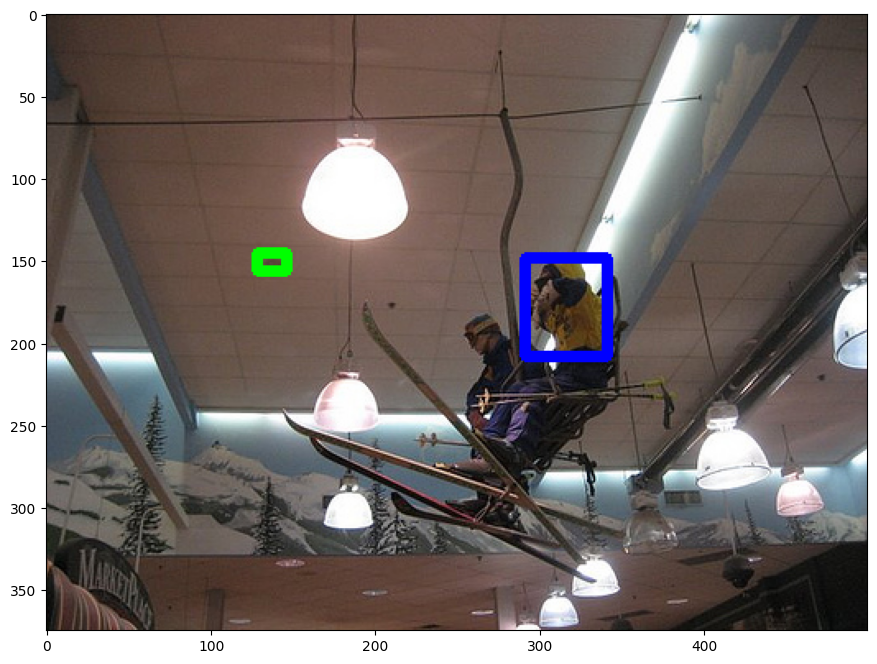

In [21]:
draw_prediction(img_url, bb_predicted, gt_bb)